# Analysis on Final Dataset

The main problem is that I have to go through multiple files and if each file naturally causes such high degree networks, it is good to initially ignore these and see if the static cut-off approach is correct!

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import pathlib
import glob

import json

import networkx as nx

import re
import uuid

Of course, there is always a slight change in the code which in the end makes it look repetative. Trying to avoid that

## Getting the information among all files

It is easy, but the original functions need to be changed and adjusted. We have to obtain the distinct authors for each file, combine them together check again for distinct authors again. It turns out that there are greek, russian an arabic people in it.

This cell gives it for individual files

In [9]:
def getUniqueAuthors(data, limit=20):
    """
    Get Unique Authors for given paper
    Needs to be done after each batch and another numpy.unique after that
    
    INPUT:
        data (json): contains publications information
    OUTPUT:
        temp_mem: contains unique authors from one batch.  
    
        
    """
    temp_mem = []
    r = re.compile(r"\s+", re.MULTILINE)
    count = 0
    for i in range(len(data['content'])):
        if ('authorships' in data['content'][i].keys() ) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):
                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    string_to_add = '' 
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    if len(string_to_add) > 0:
                        temp_mem.append(r.sub("",string_to_add))


    temp_mem = np.array(list(np.unique(temp_mem)), dtype=object)   # define it as an object
    #temp_mem = dict(zip(temp_mem, np.array(np.arange(len(temp_mem)),dtype=np.uint32 )) ) 
    return temp_mem


def getAuthorLinks(data,temp_link_list,encoder, limit=20): 
    _name_list = np.array(list(encoder.keys()))            #saving tables
    _encoded_list = np.array(list(encoder.values())) 
    
    temp_link_list = np.zeros((0,4), dtype=np.uint32)
    r = re.compile(r"\s+", re.MULTILINE)                   #for stripping some stuff

    for i in range(len(data['content'])):
        if (i+1) % 10 == 0:
            sys.stdout.write("\r {0} / {1} # {2}".format(i+1,len(data['content']), len(temp_link_list)))
            sys.stdout.flush()
        content_mem = []
        if ('authorships' in data['content'][i].keys()) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):

                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    name_to_add = ''
                    string_to_add = '' 
                    #if the field extists, get the name! -> what if none of them exists? don't give anything
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    name_to_add = r.sub("", name_to_add)
                    _encoded = _encoded_list[_name_list == name_to_add]
                    if len(_encoded) == 1:
                        content_mem.append(_encoded[0])
                    else:
                        print("Wrong amount of authors: {} != 1 !".format(len(_encoded)))

        if (len(content_mem) > 0):
            tmp_mem = []     #save partial results as constans addition is not liked by numpy
            for j in range(len(content_mem)):
                for k in np.arange(j+1,len(content_mem)):
                    tmp_mem.append([content_mem[j],
                                    content_mem[k],
                                    data['content'][i]['publishedYear'],
                                    len(data['content'][i]['authorships'])
                                   ]
                                  )
            if (len(tmp_mem) > 0): 
                temp_link_list = np.append(temp_link_list,
                                           tmp_mem,
                                           axis=0)

    temp_link_list = np.array(temp_link_list, dtype=np.uint32)
    return temp_link_list
    

This cell combines the results from individual file processing.

In [3]:
def getFilesUniqueAuthors(loc, limit=20):
    """
    Get Unique Authors for all batches, uses getUniqueAuthors
    
    INPUT:
        loc: path to the batches' folder
    OUTPUT:
        uniqueAuthorsEncoded: unique authors from all batches
    
    
    """
    uniqueAuthors = np.array([], dtype=object)   #initiate the container 
    files = os.listdir(loc)                      #get files in the given folder
    
    assert len(files) >= 1, "No files found! 1 >= {}".format(len(files))
    for i in range(len(files)):
        sub_path = loc + "/" + files[i]
        print(sub_path)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchUniqueAuthors = getUniqueAuthors(data, limit=limit)
        uniqueAuthors = np.append( uniqueAuthors, batchUniqueAuthors )

        sys.stdout.write("\rFILE: {}\t{}/{} -> {} / {}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchUniqueAuthors),
                                                               len(uniqueAuthors)))
        sys.stdout.flush()

    
            
    
    #when finished, use np.unqiue again
    bashedAmount = len(uniqueAuthors)
    
    uniqueAuthors = np.unique(uniqueAuthors)
    uniqueAuthorsEncoded = dict(zip(uniqueAuthors, np.array(np.arange(len(uniqueAuthors)), dtype=np.uint32)))
    
    print("{} to {} actually exists".format(bashedAmount,len(uniqueAuthors)))
    return uniqueAuthorsEncoded

def getFilesAuthorLinks(loc, encoder, limit=20):
    """
    Gets links beteen Unique authors to 
    
    INPUT:
        temp_link_list: contains edges
        encoder: list with encoded unique authors
        limit: limit to ignore pubications by comparing to their authourCount
    
    OUTPUT:
        VOID: modifies temp_link_ist accordingly
    
    """
    tmp_lnk_lst = np.zeros((0,4), dtype=np.uint32)      #burning in datatype
    files = os.listdir(loc)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchAuthorLinks = getAuthorLinks(data=data, temp_link_list=tmp_lnk_lst, encoder=encoder, limit=limit)
        tmp_lnk_lst = np.append( tmp_lnk_lst, batchAuthorLinks, axis=0 )
        sys.stdout.write("\rFILE: {}\t{}/{} -> {}/{}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchAuthorLinks),
                                                               len(tmp_lnk_lst)
                                                               ))
        sys.stdout.flush()
    
    return tmp_lnk_lst

In [4]:
path = "data/final"

_UniqueAuthors = getFilesUniqueAuthors(loc=path, limit=20)

data/final/publications_1.json
data/final/publications_10.json
data/final/publications_11.json
data/final/publications_12.json
data/final/publications_13.json
data/final/publications_14.json
data/final/publications_2.json
data/final/publications_3.json
data/final/publications_4.json
data/final/publications_5.json
data/final/publications_6.json
data/final/publications_7.json
data/final/publications_8.json
data/final/publications_9.json
FILE: data/final/publications_9.json	14/14 -> 7111 / 95824				95824 to 51450 actually exists


In [10]:
tmp_lnk_lst = getFilesAuthorLinks(loc=path, encoder = _UniqueAuthors, limit=20)

FILE: data/final/publications_9.json	14/14 -> 25349/338370				

In [6]:
tmp_lnk_lst[0,:]

array([22082, 13837,  2014,     0], dtype=uint32)

In [93]:
np.append(np.array([[2,2],[1,1]]), np.array([[-2,-2],[-1,-1]]))

array([ 2,  2,  1,  1, -2, -2, -1, -1])

Seems to be correct, let's progress with the original stuff


## Degree Distribution

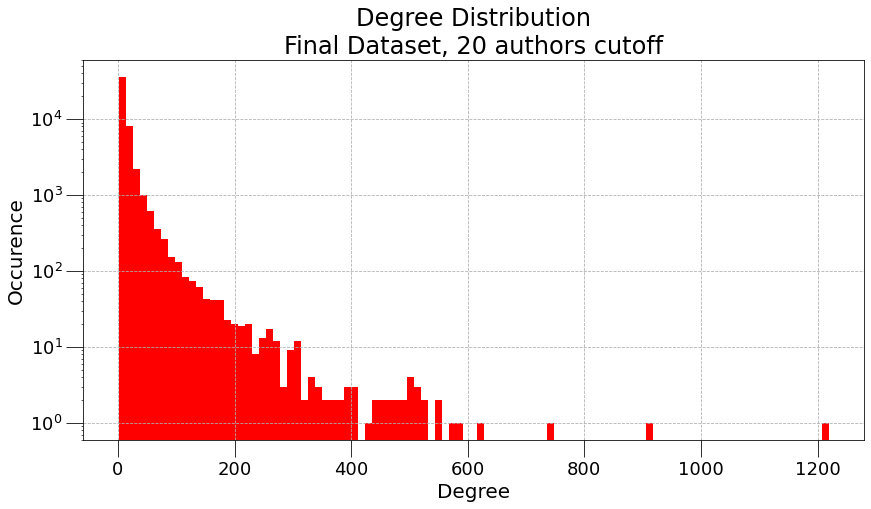

In [13]:
plt.figure(figsize=(14,7))

plt.title("Degree Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

_, deg = np.unique(tmp_lnk_lst[:,0:2].flatten(), return_counts=True)
plt.hist(deg, bins=101, color="red")

plt.xlabel("Degree", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/k_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

This seems like that on log-log scale, a line could be fitted $\rightarrow$ **Power function** could be fitted.

## Graph Representation

It could be handy to see how it looks like with the spiral layout.

In [17]:
#create the grahp object
sample_graph = nx.Graph()
sample_graph.add_edges_from(tmp_lnk_lst[:,0:2])

In [ ]:
#generate the positions of the spiral layout with initial 50 iterations
pos = nx.spring_layout(sample_graph)

In [ ]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Graph Representation of the Author Network \n with 20 authors cutoff", fontsize=34)



nx.draw_networkx_nodes(sample_graph,
                      pos,
                      nodelist = np.array(sample_graph.nodes),
                      node_size=7,
                      alpha=0.7
                      )

nx.draw_networkx_edges(sample_graph,
                      pos,
                      width=0.5,
                      edgelist=tmp_lnk_lst[:,0:2],
                      edge_color='r',
                      arrows=False)

fig.tight_layout()

plt.savefig("figs/networkx_author_network_from_final.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()